# Data Cleaning and Graph Construction

This notebook performs data cleaning and constructs the bipartite actor-movie network from the TMDb movie dataset.

## 1. Loading and Preprocessing Data

### Data Cleaning Steps

- Filter movies with valid production countries
- Convert release dates to proper format
- Remove duplicates and invalid entries
- Extract relevant attributes for network analysis

In [1]:
import pandas as pd
creds = pd.read_csv("datasets/credits.csv")
print(creds.head())
creds = creds.drop_duplicates()


                                                cast  \
0  [{'cast_id': 14, 'character': 'Woody (voice)',...   
1  [{'cast_id': 1, 'character': 'Alan Parrish', '...   
2  [{'cast_id': 2, 'character': 'Max Goldman', 'c...   
3  [{'cast_id': 1, 'character': "Savannah 'Vannah...   
4  [{'cast_id': 1, 'character': 'George Banks', '...   

                                                crew     id  
0  [{'credit_id': '52fe4284c3a36847f8024f49', 'de...    862  
1  [{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...   8844  
2  [{'credit_id': '52fe466a9251416c75077a89', 'de...  15602  
3  [{'credit_id': '52fe44779251416c91011acb', 'de...  31357  
4  [{'credit_id': '52fe44959251416c75039ed7', 'de...  11862  


## 2. Loading and Processing Movie Metadata

Loading the main movies dataset which contains information about budget, revenue, release dates, and other movie attributes.

In [2]:
movies_meta = pd.read_csv("datasets/movies_metadata.csv", low_memory=False)
print(movies_meta.head())
print(movies_meta.columns)
print(movies_meta["production_countries"])
print(movies_meta["release_date"])
movies_meta = movies_meta.fillna("")
movies_meta = movies_meta.drop_duplicates()
print("CLEAN DF")
print(movies_meta.head())

   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                                NaN  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                                NaN  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                   NaN   8844  tt0113497         

## 2. Inflation Adjustment - Purchasing Power Calculation

This cell fetches U.S. Consumer Price Index (CPI) data from 1874-2020 and calculates purchasing power relative to 2020 dollars. This allows us to adjust historical movie revenues to constant 2020 dollars for fair comparison across different eras.

**Process:**
- Fetch CPI data from MeasuringWorth.com (or load from local CSV as fallback)
- Clean and format the data
- Calculate purchasing power multiplier: `PP_2020 = CPI_2020 / CPI_year`
- Save results for revenue adjustment

**Source:** Lawrence H. Officer and Samuel H. Williamson, 'The Annual Consumer Price Index for the United States, 1774-Present,' MeasuringWorth, 2026.

In [3]:
import pandas as pd

url_complete = "https://www.measuringworth.com/datasets/uscpi/result.php?year_source=1874&year_result=2020"

try:
    # 1. Read the tables from the URL
    tables = pd.read_html(url_complete)
    
    # 2. Select the data table and clean it
    # We use the table with the most rows to ensure we get the dataset
    df = max(tables, key=len).copy()
    
    # 3. Name and format columns
    df = df.iloc[:, [0, 1]]  # Keep only the first two columns
    df.columns = ['Year', 'CPI']

except Exception as e:
    print(f"URL fetch failed ({e}), attempting to read local CSV...")
    df = pd.read_csv("USCPI_1874-2020.csv")
    # Handle the specific CSV column name if necessary
    if 'U.S. Consumer Price Index *' in df.columns:
        df = df.rename(columns={'U.S. Consumer Price Index *': 'CPI'})

# 4. Data Cleaning (Common to both sources)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
df['CPI'] = pd.to_numeric(df['CPI'], errors='coerce')

# Drop rows that are not numbers (headers/footers/notes)
df = df.dropna(subset=['Year', 'CPI'])
df['Year'] = df['Year'].astype(int)
# 5. Calculate Purchasing Power relative to 2020
# Formula: Value of $1 in Year X expressed in 2020 Dollars
try:
    cpi_2020 = df.loc[df['Year'] == 2020, 'CPI'].values[0]
    print(cpi_2020)
    df['PP_2020_Dollar'] = (cpi_2020 / df['CPI']).round(4)
    # 6. Save and Print
    df.to_csv("purchasing_power_1874_2020.csv", index=False)
    print("Success! File saved as 'purchasing_power_1874_2020.csv'")
    print(df.tail())
    
except IndexError:
    print("Error: Year 2020 not found in the dataset.")

cit = "*Citation: Lawrence H. Officer and Samuel H. Williamson, 'The Annual Consumer Price Index for the United States, 1774-Present,' MeasuringWorth, 2026. "


258.81
Success! File saved as 'purchasing_power_1874_2020.csv'
     Year     CPI  PP_2020_Dollar
143  2016  240.01          1.0783
144  2017  245.12          1.0559
145  2018  251.11          1.0307
146  2019  255.66          1.0123
147  2020  258.81          1.0000


In [4]:
import networkx as nx
from networkx.algorithms import bipartite
import ast
graph = nx.Graph()
creds["id"] = creds["id"].astype(str)
work_df = pd.merge(movies_meta[["title", "id", "genres", "original_language", "release_date", "production_countries", "revenue"]], creds[["cast", "id"]], on= "id", how ="inner")
#work_df = pd.merge(work_df, clean_ratings, on= "id", how ="left")
print(work_df.head())
print(work_df.columns)
print(work_df.iloc[0])
print(work_df["cast"].iloc[0])


                         title     id  \
0                    Toy Story    862   
1                      Jumanji   8844   
2             Grumpier Old Men  15602   
3            Waiting to Exhale  31357   
4  Father of the Bride Part II  11862   

                                              genres original_language  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...                en   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...                en   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...                en   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...                en   
4                     [{'id': 35, 'name': 'Comedy'}]                en   

  release_date                               production_countries  \
0   1995-10-30  [{'iso_3166_1': 'US', 'name': 'United States o...   
1   1995-12-15  [{'iso_3166_1': 'US', 'name': 'United States o...   
2   1995-12-22  [{'iso_3166_1': 'US', 'name': 'United States o...   
3   1995-12-22  [{'iso_3166_1': 

In [5]:
all_dates = []
for date in work_df["release_date"]:
    date = date[:4]
    if date != "":
        all_dates.append(int(date))

print(min(all_dates))
print(max(all_dates))


1874
2020


## 3. Extracting Actor Information

Parse the cast information from JSON format and extract relevant actor attributes including gender, filmography, and performance metrics.

In [6]:
titles = work_df["title"].tolist()
dates = work_df["release_date"].tolist()
print(len(titles))
clean_titles = []
seen_so_far = set()

for title, date in zip(titles, dates):
    proposed_title = title
    if proposed_title in seen_so_far:
        proposed_title = f"{title} ({date[:4]})"
    original_proposed = proposed_title
    counter = 1
    while proposed_title in seen_so_far:
        proposed_title = f"{original_proposed}_{counter}"
        counter += 1
        
    clean_titles.append(proposed_title)
    seen_so_far.add(proposed_title)

print(len(clean_titles) == len(set(clean_titles))) # Ora sarà True
print(len(clean_titles))


45456
True
45456


In [ ]:
genres = work_df["genres"].tolist()
print(len(genres)==len(clean_titles))
languages = work_df["original_language"].tolist()
dates = work_df["release_date"].tolist()
countries = work_df["production_countries"].tolist()
cast = work_df["cast"].tolist()
#ratings = work_df["avg_rating"].tolist()
revenue = work_df["revenue"].tolist()
tupled_movie = zip(clean_titles, genres, languages, dates, countries, revenue, cast)
edges = []
actors = []
movies = []
for el in list(tupled_movie):
    genres = ast.literal_eval(el[1])
    genres = [genre["name"] for genre in genres]
    if el[4] != "" and isinstance(el[4], str):
        try:
            countries = ast.literal_eval(el[4])
        except (ValueError, SyntaxError):
            countries = []
    else:
        countries = []
    clean_country = []
    if isinstance(countries,list) and len(countries) > 0:  
        for country in countries:
            if country["name"]:
                clean_country.append(country["name"])
    year = el[3]
    if year[:4].isdigit():
        year = int(year[:4])
        if el[-2]!= "" and not el[-2] is None and el[-2]!=[]:
            try:
                revenue = el[-2]/df[df["Year"] == year]["PP_2020_Dollar"].astype(float).values
                revenue = int(revenue.tolist()[0])
            except IndexError as e:
                print(el[-2])
                print(year)
    else:
        year = None
        revenue = None
    movie_attributes = {"genres": genres, "countries": clean_country, "language": el[2], "revenue_2020_$" : revenue, "release_date": year}
    el_list = ast.literal_eval(el[-1])
    if len(el_list) >0:
        movie_attributes["led_by_man"] = True if el_list[0]["gender"]== 2 else False
    else:
        movie_attributes["led_by_man"] = None
    movies.append(("movie: "+ str(el[0]), movie_attributes))
    for actor in el_list:
        # following IMDB, use top 10 actors as main characters
        top_ten = False
        if actor in el_list[:10]:
            top_ten = True
        gender = "male" if actor["gender"] == 2 else "female"
        edge_attributes = {"character" : actor["character"]}
        if len(clean_country) > 0 and clean_country != None:
            clean_country = clean_country
        else:
            clean_country = []
        actor_attributes = {"gender": gender, "countries" : clean_country, "year":year, "genres":genres, "revenue_2020_$" : revenue, "is_main" : top_ten, "movie" : "movie: "+ str(el[0])}
        actors.append(("actor: "+ actor["name"], actor_attributes))
        edges.append(("movie: "+ str(el[0]), "actor: "+ actor["name"], edge_attributes))


True


In [8]:
print(movies[-3])
print(actors[0])

('movie: Betrayal (2003)', {'genres': ['Action', 'Drama', 'Thriller'], 'countries': ['United States of America'], 'language': 'en', 'revenue_2020_$': 0, 'release_date': 2003, 'led_by_man': False})
('actor: Tom Hanks', {'gender': 'male', 'countries': ['United States of America'], 'year': 1995, 'genres': ['Animation', 'Comedy', 'Family'], 'revenue_2020_$': 219970576, 'is_main': True, 'movie': 'movie: Toy Story'})


In [9]:
print(len(movies))
print(len(actors)) 
print(len(edges))
print(actors[0])
# I want there to be a unique node for each actor
clean_actors_dict = {}


for name, attrs in actors:
    if name not in clean_actors_dict:
        new_attrs = attrs.copy()
        new_attrs["countries"] = set(attrs.get("countries") or [])
        genres = attrs.get("genres") or []
        genre_dict = dict()
        for genre in genres:
            genre_dict[genre] = 1
        new_attrs["genres"] = genre_dict
        year = attrs.get("year") or 0
        year_dict = dict()
        year_dict["early_hollywood"] = 0
        year_dict["old_hollywood"] = 0
        year_dict["new_hollywood"] = 0
        if year> 1926 and year< 1967:
            year_dict["old_hollywood"] +=1
        elif year >= 1967:
            year_dict["new_hollywood"] +=1
        elif year > 0:
            year_dict["early_hollywood"] +=1
        new_attrs["year"] = year_dict
        #new_attrs["avg_movie_rating"] = [attrs["avg_movie_rating"]]
        if not attrs["revenue_2020_$"] is None:
            new_attrs["avg_movie_revenue_2020_$"] = [int(attrs["revenue_2020_$"])]
        else:
            new_attrs["avg_movie_revenue_2020_$"] = []
        new_attrs["top_ten"] = []
        if attrs["is_main"] is True:
            if year != 0:
                new_attrs["top_ten"].append((year, attrs["movie"]))
        clean_actors_dict[name] = new_attrs
        
    else:   
        extra_countries = set(attrs.get("countries") or [])
        clean_actors_dict[name]["countries"].update(extra_countries)
        extra_genres = attrs.get("genres") or []
        for genre in extra_genres:
            if genre not in clean_actors_dict[name]["genres"]:
                clean_actors_dict[name]["genres"][genre] = 1
            else: 
                clean_actors_dict[name]["genres"][genre] +=1
        current_year = attrs["year"] or 0
        if current_year> 1926 and current_year< 1967:
            clean_actors_dict[name]["year"]["old_hollywood"] +=1
        elif current_year >= 1967:
            clean_actors_dict[name]["year"]["new_hollywood"] +=1
        elif current_year <1927:
            clean_actors_dict[name]["year"]["early_hollywood"] +=1
        #clean_actors_dict[name]["avg_movie_rating"].append(attrs["avg_movie_rating"])
        if not attrs["revenue_2020_$"] is None:
            clean_actors_dict[name]["avg_movie_revenue_2020_$"].append(int(attrs["revenue_2020_$"]))
        if attrs["is_main"] is True:
            if current_year != 0:
                clean_actors_dict[name]["top_ten"].append((current_year, attrs["movie"]))


final_actors = []

for name, attrs in clean_actors_dict.items():
    attrs["countries"] = list(attrs["countries"])
    genres = list(attrs["genres"].items())
    sorted_genres = sorted(genres, key=lambda x: x[1], reverse = True)
    if len(sorted_genres)> 0:
        attrs["genre"] = sorted_genres[0][0]
    else:
        attrs["genre"] = ""
    attrs["all_genres"] = [name for name, _ in sorted_genres]
    periods = list(attrs["year"].items())
    del attrs["genres"]
    sorted_periods = sorted(periods, key=lambda x: x[1], reverse = True)
    attrs["period"] = sorted_periods[0][0]
    del attrs["year"]
    #attrs["avg_movie_rating"] = sum(attrs["avg_movie_rating"]) /len(attrs["avg_movie_rating"])
    if len(attrs["avg_movie_revenue_2020_$"]) != 0:
        attrs["avg_movie_revenue_2020_$"] = int(sum(attrs["avg_movie_revenue_2020_$"])/ len(attrs["avg_movie_revenue_2020_$"]))
    else:
        attrs["avg_movie_revenue_2020_$"] = 0
    del attrs["revenue_2020_$"]
    final_actors.append((name, attrs))
    del attrs["is_main"]
    del attrs["movie"]


print(f"Unique actors found: {len(final_actors)}")
print(len(final_actors))
print(final_actors[0])


45456
562330
562330
('actor: Tom Hanks', {'gender': 'male', 'countries': ['United States of America'], 'year': 1995, 'genres': ['Animation', 'Comedy', 'Family'], 'revenue_2020_$': 219970576, 'is_main': True, 'movie': 'movie: Toy Story'})
Unique actors found: 202747
202747
('actor: Tom Hanks', {'gender': 'male', 'countries': ['Germany', 'Malta', 'India', 'Australia', 'United Kingdom', 'Italy', 'Hong Kong', 'United States of America', 'France', 'Mexico', 'Hungary', 'Singapore'], 'avg_movie_revenue_2020_$': 97984814, 'top_ten': [(1995, 'movie: Toy Story'), (1995, 'movie: Apollo 13'), (1994, 'movie: Forrest Gump'), (1993, 'movie: Philadelphia'), (1993, 'movie: Sleepless in Seattle'), (1996, 'movie: That Thing You Do!'), (1998, 'movie: Saving Private Ryan'), (1989, "movie: The 'Burbs"), (1984, 'movie: Splash'), (1986, 'movie: The Money Pit'), (1986, 'movie: Nothing in Common'), (1998, "movie: You've Got Mail"), (1988, 'movie: Big'), (1999, 'movie: Return with Honor'), (1999, 'movie: Toy Sto

## 4. Building the Bipartite Network

Construct a bipartite graph where:
- One set of nodes represents actors
- Another set represents movies
- Edges connect actors to movies they appeared in

In [10]:
import networkx as nx 
graph = nx.Graph()
for movie, diz in movies:
    graph.add_node(movie, **diz, bipartite = 0)
for actor, diz in final_actors:
    if not isinstance(diz["genre"], str):
        print(diz)
    graph.add_node(actor, **diz, bipartite = 1)
for edge1, edge2, diz in edges:
    graph.add_edge(edge1, edge2, **diz)

In [11]:
import json
to_dump = nx.readwrite.json_graph.node_link_data(graph)
with open("full_graph.json", "w") as f:
    json.dump(to_dump, f)


In [12]:
movie_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 0}
actor_nodes = {n for n, d in graph.nodes(data=True) if d["bipartite"] == 1}

In [13]:
# let's create a graph only for the movies produced in Hollywood (movies produced by the US, with co-production with other countries allowed)
hollywood_graph = nx.Graph()

movie_counter = 0
for movie, diz in movies:
    if "United States of America" in diz["countries"]:
        movie_counter += 1
        hollywood_graph.add_node(movie, **diz, bipartite = 0)
print(movie_counter)
actor_counter = 0
for actor, diz in final_actors:
    if "United States of America" in diz["countries"]:
        actor_counter +=1
        hollywood_graph.add_node(actor, **diz, bipartite = 1)
print(actor_counter)
edge_counter = 0
for edge1, edge2, diz in edges:
    if edge1 in hollywood_graph.nodes() and edge2 in hollywood_graph.nodes():
        edge_counter +=1
        hollywood_graph.add_edge(edge1, edge2, **diz)


21154
111458


In [14]:
movie_dict = dict()
actor_dict = dict()
for n, d in hollywood_graph.nodes(data=True): 
    if d["bipartite"] == 0:
        movie_dict[n] = d
for n, d in hollywood_graph.nodes(data=True): 
    if d["bipartite"] == 1:
        actor_dict[n] = d

### 4.1 Node Attributes

Each actor node includes:
- Demographics (gender, nationality)
- Career metrics (breakthrough year, revenue, period)
- Awards (Oscar nominations)
- Filmography details

Each movie node includes:
- Release date
- Budget and revenue
- Genres
- Production information

In [15]:
print(list(actor_dict.items())[:10])

[('actor: Tom Hanks', {'gender': 'male', 'countries': ['Germany', 'Malta', 'India', 'Australia', 'United Kingdom', 'Italy', 'Hong Kong', 'United States of America', 'France', 'Mexico', 'Hungary', 'Singapore'], 'avg_movie_revenue_2020_$': 97984814, 'top_ten': [(1995, 'movie: Toy Story'), (1995, 'movie: Apollo 13'), (1994, 'movie: Forrest Gump'), (1993, 'movie: Philadelphia'), (1993, 'movie: Sleepless in Seattle'), (1996, 'movie: That Thing You Do!'), (1998, 'movie: Saving Private Ryan'), (1989, "movie: The 'Burbs"), (1984, 'movie: Splash'), (1986, 'movie: The Money Pit'), (1986, 'movie: Nothing in Common'), (1998, "movie: You've Got Mail"), (1988, 'movie: Big'), (1999, 'movie: Return with Honor'), (1999, 'movie: Toy Story 2'), (1990, 'movie: The Bonfire of the Vanities'), (1999, 'movie: The Green Mile'), (1992, 'movie: A League of Their Own'), (1985, 'movie: Volunteers'), (1984, 'movie: Bachelor Party'), (1988, 'movie: Punchline'), (2000, 'movie: Cast Away'), (1989, 'movie: Turner & Hoo

In [16]:
import csv
oscars = list()
with open('full_data.csv', newline='\n') as csvfile:
    reader = csv.DictReader(csvfile, delimiter= "\t")
    try:
        for row in reader:
            if row["Class"] == "Acting":
                oscars.append(row)
    except:
        if row["Class"] =="Acting":
            print(row)


#print(oscars[-2])
new_info= dict()

# first choice as measure of breakthrough: oscar nomination

for el in oscars:
    if '/' in el["Year"]:
        year = int(el["Year"].split("/")[0])
    else:
        year = int(el["Year"])
    if "actor: "+ el["Name"] not in new_info:
        new_info["actor: "+ el["Name"]] = dict()
        new_info["actor: "+el["Name"]]["breakthrough"] = year
        new_info["actor: "+el["Name"]]["oscar_nomination"] = True
        # one of the metrics to measure successful career
        new_info["actor: "+el["Name"]]["successive_noms"] = 0
    else:
        new_info["actor: " + el["Name"]]["breakthrough"] = min(year, new_info["actor: " + el["Name"]]["breakthrough"])
        new_info["actor: "+el["Name"]]["successive_noms"] +=1
        
    #print(new_info)


print(new_info["actor: Tom Hanks"])
# print(list(actor_dict.keys())[0])

oscar_noms = set(new_info.keys())
all_actors = set(actor_dict.keys())
to_do = list(all_actors - oscar_noms)


{'breakthrough': 1988, 'oscar_nomination': True, 'successive_noms': 5}


In [17]:
# fallback measure: annus mirabilis

for actor in to_do:
    neighbors = actor_dict[actor]["top_ten"]
    year_movies = dict()
    for year, movie in neighbors:
        if movie in movie_dict:
            if not year is None and (isinstance(year, int) or year.isdigit()):
                if year not in year_movies:
                    year_movies[year] = 1
                else:
                    year_movies[year] +=1
    new_info[actor] = dict()
    new_info[actor]["successive_noms"] = 0
    sort_productivity = sorted(list(year_movies.items()), key=lambda x: x[1], reverse = True)
    if len(sort_productivity)>0:
        bk = sort_productivity[0][0]
        sort_period = sorted([x for x in sort_productivity if x[0] > bk], key=lambda x: x[0])
        new_info[actor]["breakthrough"] = bk
    else:
        new_info[actor]["breakthrough"] = None
        sort_period = []
    new_info[actor]["oscar_nomination"] = False
    # to monitor longevity (how many years of activity after breakup)
    # to monitor yearly market share (number of featured movies vs total number of movies that year) 
    new_info[actor]["post_breakthrough_movies_year"] = sort_period

print(list(new_info.items())[-10:])


[('actor: Amanda Lund', {'successive_noms': 0, 'breakthrough': 2011, 'oscar_nomination': False, 'post_breakthrough_movies_year': [(2014, 1), (2015, 1)]}), ('actor: Louie Rankin', {'successive_noms': 0, 'breakthrough': 1998, 'oscar_nomination': False, 'post_breakthrough_movies_year': [(2002, 1)]}), ('actor: Frank Dux', {'successive_noms': 0, 'breakthrough': 1993, 'oscar_nomination': False, 'post_breakthrough_movies_year': []}), ('actor: Reynaldo Silva', {'successive_noms': 0, 'breakthrough': None, 'oscar_nomination': False, 'post_breakthrough_movies_year': []}), ('actor: Kathleen Crowley', {'successive_noms': 0, 'breakthrough': 1969, 'oscar_nomination': False, 'post_breakthrough_movies_year': []}), ('actor: L. Derek Leonidoff', {'successive_noms': 0, 'breakthrough': 2010, 'oscar_nomination': False, 'post_breakthrough_movies_year': []}), ('actor: Amy Brooks', {'successive_noms': 0, 'breakthrough': 1989, 'oscar_nomination': False, 'post_breakthrough_movies_year': []}), ('actor: Regan Burn

In [18]:

for actor in oscar_noms:
    if actor in actor_dict:
        neighbors = actor_dict[actor]["top_ten"]
        year_movies = dict()
        for year, movie in neighbors:
            if movie in movie_dict:
                if not year is None and (isinstance(year, int) or year.isdigit()):
                    if year not in year_movies:
                        year_movies[year] = 1
                    else:
                        year_movies[year] +=1
        sort_productivity = sorted(list(year_movies.items()), key=lambda x: x[1], reverse = True)
        bk = new_info[actor]["breakthrough"]
        if len(sort_productivity)>0:
            sort_period = sorted([x for x in sort_productivity if x[0] > bk], key=lambda x: x[0])
        else:
            sort_period = []
        # to monitor longevity (how many years of activity after breakup)
        # to monitor yearly market share (number of featured movies as main_cast vs total number of movies that year) 
        new_info[actor]["post_breakthrough_movies_year"] = sort_period


In [19]:
print(new_info["actor: Tom Hanks"])
for actor, data in new_info.items():
    if actor in hollywood_graph:
        hollywood_graph.nodes[actor].update(data)

{'breakthrough': 1988, 'oscar_nomination': True, 'successive_noms': 5, 'post_breakthrough_movies_year': [(1989, 2), (1990, 2), (1992, 2), (1993, 2), (1994, 1), (1995, 2), (1996, 1), (1998, 3), (1999, 2), (2000, 2), (2002, 2), (2004, 4), (2006, 2), (2007, 3), (2008, 1), (2009, 1), (2010, 1), (2011, 4), (2012, 2), (2013, 4), (2014, 2), (2015, 3), (2016, 3), (2017, 1)]}


In [20]:
# measuring success
# actor is successful if:
    # - has oscar nominations after breakthrough and at least 10 yrs of activity (vs one-hit wonders)
    # - has 1st quartile marketshare per period (10 yrs) and was within top 10 cast

In [21]:
actors_decade_productivity = dict()
for actor in actor_dict:
    actors_decade_productivity[actor] = dict()
    try:
        post_break_years = [tup[0] for tup in new_info[actor]["post_breakthrough_movies_year"]]
        post_break_movies = [tup[1] for tup in new_info[actor]["post_breakthrough_movies_year"]]
        for decade in range(1871, 2021, 10):
            actors_decade_productivity[actor][f"{decade}-{decade+9}"] = 0
            for year in range(decade, decade+10):
                if len(post_break_years) > 0:
                    for i in range(len(post_break_years)):
                        if year== post_break_years[i]:
                            actors_decade_productivity[actor][f"{decade}-{decade+9}"] += post_break_movies[i]
    except:
        print(actor)
        print(new_info[actor])

print(len(actors_decade_productivity))


111458


In [22]:
print(actors_decade_productivity["actor: Tom Hanks"])

{'1871-1880': 0, '1881-1890': 0, '1891-1900': 0, '1901-1910': 0, '1911-1920': 0, '1921-1930': 0, '1931-1940': 0, '1941-1950': 0, '1951-1960': 0, '1961-1970': 0, '1971-1980': 0, '1981-1990': 4, '1991-2000': 15, '2001-2010': 14, '2011-2020': 19}


In [23]:
# df_year = pd.read_csv("title_basics.tsv", sep="\t")
# print(df_year.head())
# df_year.to_csv("title_basics.csv", index=False)

In [24]:
df_year = pd.read_csv("title_basics.csv")
df_year = df_year[df_year["startYear"]!="\\N"]
df_year["startYear"] = df_year["startYear"].astype(int)
df_year_movies = df_year[["titleType", "startYear"]][(df_year["titleType"] == "movie") & (df_year["startYear"]< 2021)]
df_year_movies_grouped = df_year_movies.groupby(["startYear"]).count()
print(df_year_movies_grouped.head())
print(df_year_movies_grouped.tail())

           titleType
startYear           
1894               1
1896               1
1897               2
1898               6
1899               8
           titleType
startYear           
2016           18723
2017           19198
2018           19480
2019           19448
2020           16699


In [25]:
print(df_year_movies_grouped.columns)
df_year_movies_grouped = df_year_movies_grouped.reset_index()
print(df_year_movies_grouped.head())
print(df_year_movies_grouped.columns)

Index(['titleType'], dtype='object')
   startYear  titleType
0       1894          1
1       1896          1
2       1897          2
3       1898          6
4       1899          8
Index(['startYear', 'titleType'], dtype='object')


In [26]:
recorded_years = df_year_movies_grouped["startYear"].tolist()
movie_per_year = dict()
for movie in movie_dict:
    year = movie_dict[movie]["release_date"]
    if not year is None:
        year = int(year)
        if year not in recorded_years:
            if year not in movie_per_year:
                movie_per_year[year] = 1
            else:
                movie_per_year[year] +=1

year_movies_df = pd.DataFrame({"startYear" : list(movie_per_year.keys()), "titleType": list(movie_per_year.values())})
year_movies = pd.concat([df_year_movies_grouped, year_movies_df],ignore_index=True )
year_movies = year_movies.sort_values(by="startYear")
year_movies.columns = ["year","movies_per_year"]


In [27]:
years_of_movie = year_movies["year"].tolist()
movies_of_year = year_movies["movies_per_year"].tolist()
decade_movies_dict = dict()
for decade in range(1871, 2021, 10):
    decade_movies_dict[f"{decade}-{decade+9}"] = 0
    for year in range(decade, decade+10):
        for i in range(len(movies_of_year)):
            if year == years_of_movie[i]:
                decade_movies_dict[f"{decade}-{decade+9}"] += movies_of_year[i]

print(decade_movies_dict)
with open("movies_per_decade.json", "w") as f:
    json.dump(decade_movies_dict, f)


{'1871-1880': 1, '1881-1890': 5, '1891-1900': 33, '1901-1910': 277, '1911-1920': 15525, '1921-1930': 21482, '1931-1940': 20322, '1941-1950': 14946, '1951-1960': 24786, '1961-1970': 33110, '1971-1980': 40577, '1981-1990': 45212, '1991-2000': 46627, '2001-2010': 86424, '2011-2020': 172740}


In [28]:
with open("movies_per_decade.json") as f:
    decade_movies_dict = json.load(f)

In [29]:
import numpy as np
decade_movies_values = np.array(list(decade_movies_dict.values()))
decade_movies_keys = list(decade_movies_dict.keys())
normalized_actors_productivity = dict()
for actor in actors_decade_productivity:
    norm_prod = dict()
    actors_prod = np.array(list(actors_decade_productivity[actor].values()))
    actors_prod_norm = list(actors_prod/decade_movies_values)
    norm_prod[actor] = dict()
    for i in range(len(decade_movies_keys)):
        norm_prod[actor][decade_movies_keys[i]] = float(actors_prod_norm[i])
    normalized_actors_productivity[actor] = norm_prod[actor]

print(normalized_actors_productivity["actor: Tom Hanks"])



{'1871-1880': 0.0, '1881-1890': 0.0, '1891-1900': 0.0, '1901-1910': 0.0, '1911-1920': 0.0, '1921-1930': 0.0, '1931-1940': 0.0, '1941-1950': 0.0, '1951-1960': 0.0, '1961-1970': 0.0, '1971-1980': 0.0, '1981-1990': 8.847208705653367e-05, '1991-2000': 0.00032170201814399384, '2001-2010': 0.00016199203924835694, '2011-2020': 0.00010999189533402802}


In [30]:


decade_years = dict()
for el in decade_movies_keys:
    decade_years[el] = []
    el_split = el.split("-")
    for year in range(int(el_split[0]), int(el_split[1])+1):
        decade_years[el].append(year)

best_decade = dict()
decade_keys = list(decade_years.keys())

no_bk = list()
all_bk = list()

for actor in all_actors:
    bk = new_info[actor]["breakthrough"]
    if not bk is None:
        for i, decade in enumerate(decade_keys):
            if bk in decade_years[decade]:
                best_value = normalized_actors_productivity[actor][decade]
                best_d = decade
                if i + 1 < len(decade_keys):
                    next_decade_key = decade_keys[i + 1]
                    if normalized_actors_productivity[actor][next_decade_key] > best_value:
                        best_value = normalized_actors_productivity[actor][next_decade_key]
                        best_d = next_decade_key
                best_decade[actor] = best_d
                if best_value == 0:
                    del best_decade[actor]
                break
        all_bk.append(actor)
    else:
        no_bk.append(actor)

# actors who had at least one major role after their breakthrough
one_hit_wonder = list(set(all_bk) - set(best_decade.keys()))

print(len(actor_dict) == len(one_hit_wonder) + len(best_decade) + len(no_bk))
print("Actors who never had a breakthrough (no a major role):", len(no_bk))
print("Actors who were true one-hit wonders:", len(one_hit_wonder))
print("Actors who still got at least one relevant roles after their breakthrough:", len(best_decade))               
        

True
Actors who never had a breakthrough (no a major role): 55564
Actors who were true one-hit wonders: 40549
Actors who still got at least one relevant roles after their breakthrough: 15345


In [31]:
print(best_decade["actor: Tom Hanks"])

1991-2000


In [32]:
actors_dict_updated = dict()
for n, d in hollywood_graph.nodes(data=True): 
    if d["bipartite"] == 1:
        actors_dict_updated[n] = d

In [33]:
# actors marketshare analysis
print(len(best_decade))

rows = []

for actor in best_decade:
    period = actors_dict_updated[actor]["period"]
    if actor in normalized_actors_productivity:
        for decade, mshare in normalized_actors_productivity[actor].items():
            if mshare> 0:
                rows.append({'Actor': actor, 'Decade': decade, 'Market Share': mshare, "Period":period})

df_plot = pd.DataFrame(rows)
print(len(df_plot))
print(df_plot[df_plot["Decade"] == "1981-1990"])

15345
24802
                             Actor     Decade  Market Share         Period
7            actor: Michael Miller  1981-1990      0.000044  new_hollywood
12            actor: Oliver Robins  1981-1990      0.000022  new_hollywood
35            actor: Daryl Edwards  1981-1990      0.000022  new_hollywood
37               actor: Bill Erwin  1981-1990      0.000044  new_hollywood
47            actor: Michael Sacks  1981-1990      0.000022  new_hollywood
...                            ...        ...           ...            ...
24752          actor: Philip Bruns  1981-1990      0.000022  new_hollywood
24756         actor: Pat McCormick  1981-1990      0.000022  new_hollywood
24763           actor: Roger Moore  1981-1990      0.000088  new_hollywood
24768           actor: John Marley  1981-1990      0.000022  new_hollywood
24784  actor: David James Campbell  1981-1990      0.000022  new_hollywood

[2011 rows x 4 columns]


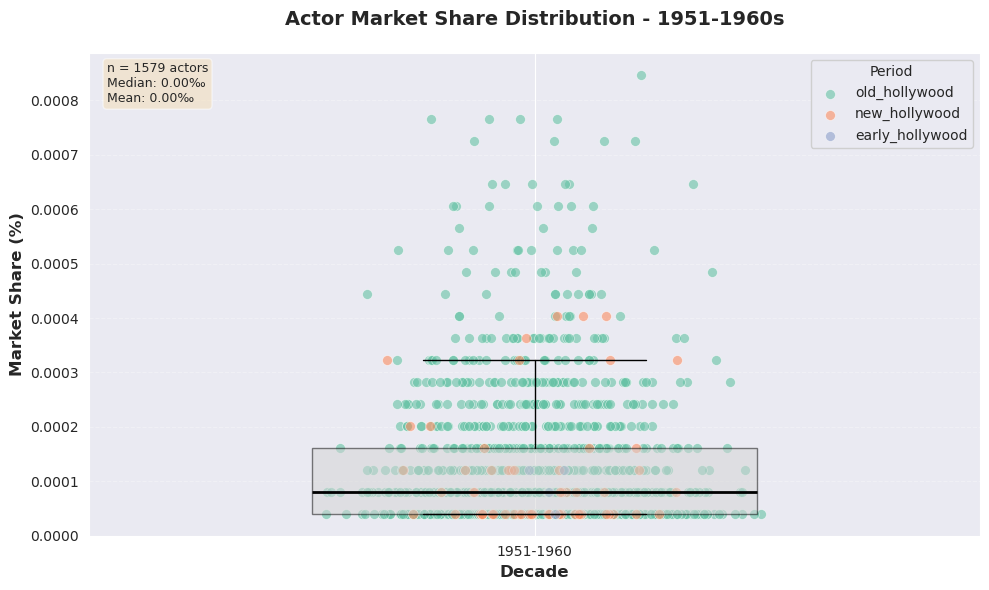

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


def plot_marketshare_single_decade(df_plot, decade, figsize=(10, 6)):
    """
    Creates a boxplot of market share for a single decade, with points colored by period.
    
    Parameters:
    -----------
    df_plot : pd.DataFrame
        DataFrame with columns 'Actor', 'Decade', 'Market Share', 'Period'
    decade : int or str
        The decade to plot (e.g., 1950, 1980)
    figsize : tuple
        Figure size (width, height)
    """
    # Filter data for the selected decade
    decade_data = df_plot[df_plot['Decade'] == decade].copy()
    
    if len(decade_data) == 0:
        print(f"No data available for decade {decade}")
        return None, None
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique periods
    periods = decade_data['Period'].unique()
    
    # Define color palette
    palette = sns.color_palette("Set2", n_colors=len(periods))
    period_colors = {period: palette[i] for i, period in enumerate(periods)}
    
    # Create boxplot (without showing outliers to avoid duplication)
    ax.boxplot([decade_data['Market Share'].values],
               positions=[0],
               widths=0.5,
               patch_artist=True,
               showfliers=False,
               boxprops=dict(facecolor='lightgray', alpha=0.5),
               medianprops=dict(color='black', linewidth=2))
    
    # Overlay individual points colored by period
    for period in periods:
        period_data = decade_data[decade_data['Period'] == period]
        
        # Add jitter to x-axis for better visibility
        x_jitter = np.random.normal(0, 0.08, size=len(period_data))
        
        ax.scatter(x_jitter, 
                  period_data['Market Share'],
                  color=period_colors[period],
                  alpha=0.6,
                  s=50,
                  label=period,
                  edgecolors='white',
                  linewidth=0.5)
    
    # Formatting
    ax.set_xticks([0])
    ax.set_xticklabels([str(decade)])
    ax.set_xlabel('Decade', fontsize=12, fontweight='bold')
    ax.set_ylabel('Market Share (%)', fontsize=12, fontweight='bold')
    ax.set_title(f'Actor Market Share Distribution - {decade}s', 
                 fontsize=14, fontweight='bold', pad=20)
    
    # Legend
    ax.legend(title='Period', loc='upper right', framealpha=0.9)
    
    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add statistics text
    stats_text = f"n = {len(decade_data)} actors\n"
    stats_text += f"Median: {decade_data['Market Share'].median():.2f}‰\n"
    stats_text += f"Mean: {decade_data['Market Share'].mean():.2f}‰"
    
    ax.text(0.02, 0.98, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=9)
    
    plt.tight_layout()
    
    return fig, ax

# Usage example:
fig, ax = plot_marketshare_single_decade(df_plot, decade="1951-1960")
plt.show()

In [35]:
quartile_dict = dict()
for decade in decade_keys:
    quartile_dict[decade] = dict()
    q3_threshold = df_plot[df_plot["Decade"] == decade]['Market Share'].quantile(0.75)
    quartile_dict[decade]["q3_treshold"] = q3_threshold
    top_actors = df_plot[df_plot['Market Share'] >= q3_threshold]["Actor"]
    quartile_dict[decade]["actors_above"] = top_actors



## 5. Actor Classification by Career Success

We classify actors into different tiers based on their career trajectories:
- **Stars**: Sustained major roles throughout career
- **Emergents**: Rising actors with increasing prominence
- **A-listers**: Elite actors with critical recognition (Oscar nominations)
- **One-hit wonders**: Actors with a single breakthrough
- **Background**: Actors who never achieved major roles

In [36]:
# let's determine who is a successful actor
successful_actors = []
for actor in best_decade:
    best_d = best_decade[actor]
    # has had an oscar nomination AND had at least other 10 years of activity
    if new_info[actor]["oscar_nomination"] and len(new_info[actor]["post_breakthrough_movies_year"]) >=10:
        successful_actors.append(actor)
    # is in the third quartile or above in their best year
    elif actor in quartile_dict[best_d]["actors_above"]:
        successful_actors.append(actor)

print("A-listers:", len(successful_actors))
print("Non A-listers:",  len(best_decade) - len(successful_actors))

print(successful_actors)

A-listers: 453
Non A-listers: 14892
['actor: Emily Watson', 'actor: Spring Byington', 'actor: Helen Mirren', 'actor: Lewis Stone', 'actor: George Sanders', 'actor: Frank Morgan', 'actor: Chazz Palminteri', 'actor: Dorothy McGuire', 'actor: William Hurt', 'actor: Hope Lange', 'actor: Sissy Spacek', 'actor: Montgomery Clift', 'actor: Rock Hudson', 'actor: Glenn Close', 'actor: Merle Oberon', "actor: Dan O'Herlihy", 'actor: Don Murray', 'actor: John Cassavetes', 'actor: Talia Shire', 'actor: James Earl Jones', 'actor: Gene Hackman', 'actor: Theodore Bikel', 'actor: Gene Wilder', 'actor: Henry Fonda', 'actor: Joan Cusack', 'actor: Jackie Cooper', 'actor: Marcia Gay Harden', 'actor: Gwyneth Paltrow', 'actor: Samuel L. Jackson', 'actor: Natalie Wood', 'actor: Woody Harrelson', 'actor: Raymond Massey', 'actor: Shirley Jones', 'actor: John C. Reilly', 'actor: Julie Andrews', 'actor: Dianne Wiest', 'actor: Matt Damon', 'actor: Miranda Richardson', 'actor: Donald Crisp', 'actor: Harvey Keitel', 

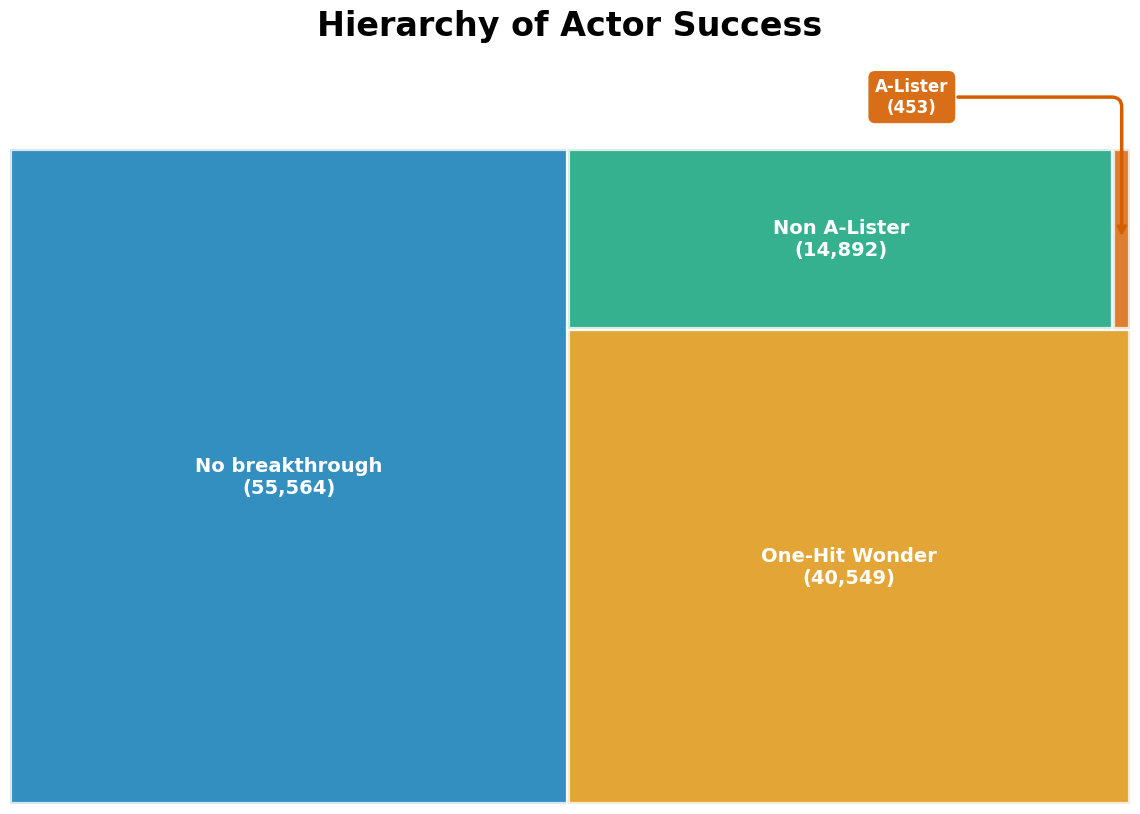

In [2]:
import matplotlib.pyplot as plt
import squarify
import seaborn as sns

# 1. Dati
data = {
    'No breakthrough': 55564,
    'One-Hit Wonder': 40549,
    'Non A-Lister': 14892,
    'A-Lister': 453
}

# Ordinamento per dimensione (fondamentale per squarify)
data = dict(sorted(data.items(), key=lambda item: item[1], reverse=True))
values = list(data.values())
labels = list(data.keys())

# 2. Setup Plot
fig, ax = plt.subplots(figsize=(14, 9), dpi=100)
# Usiamo la palette viridis (il verde/giallo sarà associato all'area più piccola)
colors = sns.color_palette("colorblind", len(labels))

# Calcolo coordinate
x, y, width, height = 0, 0, 100, 100
norm_values = squarify.normalize_sizes(values, width, height)
rects = squarify.squarify(norm_values, x, y, width, height)

for rect, label, value, color in zip(rects, labels, values, colors):
    ax.add_patch(plt.Rectangle((rect['x'], rect['y']), rect['dx'], rect['dy'], 
                               facecolor=color, alpha=0.8, edgecolor='white', linewidth=3))
    
    text_label = f"{label}\n({value:,})"

    if label == "A-Lister":
        ax.annotate(text_label, 
                    xy=(rect['x'] + rect['dx']/2, rect['y'] + rect['dy']/2), 
                    xytext=(rect['x'] - 18, rect['y'] + rect['dy'] + 8), # Spostato più a sinistra e in alto
                    fontsize=12,
                    fontweight='bold',
                    color='white',
                    ha='center',
                    va='center',
                    bbox=dict(boxstyle="round,pad=0.4", facecolor=color, edgecolor='none', alpha=0.9),
                    arrowprops=dict(arrowstyle="->", 
                                    connectionstyle="angle,angleA=0,angleB=90,rad=10", 
                                    color=color, 
                                    lw=2.5))
    
    else:
        tx = rect['x'] + rect['dx'] / 2
        ty = rect['y'] + rect['dy'] / 2
        ax.text(tx, ty, text_label, 
                color='white', 
                weight='bold', 
                fontsize=14, 
                ha='center', 
                va='center')

ax.set_xlim(0, 100)
ax.set_ylim(0, 110)
plt.axis('off')

plt.title("Hierarchy of Actor Success",fontsize=24, pad=30, weight='bold', va="bottom")

plt.subplots_adjust(left=0.15, right=0.95, top=0.85, bottom=0.05)
plt.savefig("hierarchy_success.jpg")

plt.show()

True
Actors who never had a breakthrough (no a major role): 55564
Actors who were true one-hit wonders: 40549
Actors who still got at least one relevant roles after their breakthrough: 15345

In [37]:
almost_successful = list(set(best_decade) - set(successful_actors))
almost_successful_dict = dict()
for actor in almost_successful:
    almost_successful_dict[actor] = actors_dict_updated[actor]
    almost_successful_dict[actor]["best_period"] = best_decade[actor]

df_almost_success = pd.DataFrame(almost_successful_dict)
df_almost_success.to_json("almost_successful_actors.json")

In [38]:
success_dict = dict()
for actor in successful_actors:
    success_dict[actor] = actors_dict_updated[actor]
    success_dict[actor]["best_period"] = best_decade[actor]

df_success = pd.DataFrame(success_dict)
df_success.to_json("successful_actors.json")

In [39]:
print(df_success["actor: Tom Hanks"])

gender                                                                        male
countries                        [Germany, Malta, India, Australia, United King...
avg_movie_revenue_2020_$                                                  97984814
top_ten                          [(1995, movie: Toy Story), (1995, movie: Apoll...
genre                                                                       Comedy
all_genres                       [Comedy, Drama, Documentary, Family, Animation...
period                                                               new_hollywood
bipartite                                                                        1
breakthrough                                                                  1988
oscar_nomination                                                              True
successive_noms                                                                  5
post_breakthrough_movies_year    [(1989, 2), (1990, 2), (1992, 2), (1993, 2), (...
best

In [40]:
import json
to_dump = nx.readwrite.json_graph.node_link_data(hollywood_graph)

with open("hollywood_graph.json", "w") as f:
    json.dump(to_dump, f)
